<h1><center> Analisi della distribuzione di miscentering di ammassi eROSITA</center></h1>
<h3><center>Cristina Alina Goga</center></h3>

## 1. Introduzione

Di seguito si è implementato un codice Python per l'analisi della distribuzione degli offset tra i
centri degli ammassi di galassie osservati in banda X e in banda ottica, utilizzando la prima data release della survey eROSITA (febbraio 2024). Per descrivere la miscentering distribution vengono proposti e studiati il Modello S15 (Saro et al. 2015) ed il Modello Z19 (Zhang et al. 2019).

## 2. Analisi del catalogo 

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
from getdist import plots, MCSamples
import pygtc
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

#Si definiscono le funzioni utilizzate in seguito: i due modelli per la distribuzione dei dati 
#analizzati e le prior, likelihood e posterior distribution per entrambi i modelli,
#per l'analisi bayesiana del campione.

def model_S15(theta, x):
    
    '''    Modello S15 per la descrizione della miscentering distribution.
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
    x: array_like, valori di offset per cui viene valutata la probability distribution function

    Risultato
    ----------------
    Il valore atteso della probability distribution function, secondo il modello S15.'''
    
    rho, s0,s1 = theta
    return rho*(x/(s0**2))*np.exp(-0.5*(x/s0)**2)+(1-rho)*(x/(s1**2))*np.exp(-0.5*(x/s1)**2)

def model_Z19(theta,x):
    '''    Modello Z19 per la descrizione della miscentering distribution.
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
    x: array_like, valori di offset per cui viene valutata la probability distribution function

    Risultato
    ----------------
    Il valore atteso della probability distribution function, secondo il modello Z19.'''
    rho, s0, s1 = theta
    return (rho/s0)*np.exp(-x/s0)+(1-rho)*(x/(s1**2))*np.exp(-x/s1)

def log_prior(theta):
    ''' Calcola il logaritmo della prior distribution dei parametri della miscentering distribution, 
    assumenta essere piatta per valori positivi di sigma_0 e sigma_1 e per rho compreso tra 0 e 1
    inclusi.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipendono
           i modelli
           
    Risultato
    ----------------
    Il logaritmo della prior distribution.'''
    rho, s0, s1 = theta
    if  0<=rho<=1 and s0>0  and s1>0:
        return  0.0
    return -np.inf

def log_likelihood_S15(theta, x):
    '''    Calcola il logaritmo della funzione di likelihood, assumendo il modello S15 per la 
    descrizione dei dati (indipendenti tra loro).
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la likelihood.
           
    Risultato
    ----------------
    Il logaritmo della della funzione di likelihood. '''
    rho, s0, s1 = theta
    return np.nansum(np.log(model_S15(theta ,x)))

def log_likelihood_Z19(theta, x):
    '''    Calcola il logaritmo della funzione di likelihood, assumendo il modello Z19 per la 
    descrizione dei dati (indipendenti tra loro).
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la likelihood.
           
    Risultato
    ----------------
    Il logaritmo della funzione di likelihood. '''
    rho, s0, s1 = theta
    return np.nansum(np.log(model_Z19(theta ,x)))   

def log_posterior_S15(theta, x):
    '''    Calcola il logaritmo della posterior distribution, assumendo il modello S15 per la 
    descrizione dei dati.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la posterior distribution.
           
    Risultato
    ----------------
    Il logaritmo della posterior distribution. '''
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_S15(theta, x)

def log_posterior_Z19(theta, x):
    '''Calcola il logaritmo della funzione di likelihood, assumendo il modello Z19 per la descrizione 
    dei dati.
    
    Argomenti
    ----------------
    theta: array_like, 3 componenti, in ordine i parametri  rho, sigma_0 e sigma_1 da cui dipende
           il modello
           
    x: array_like, valori di offset per cui viene valutata la posterior distribution.
           
    Risultato
    ----------------
    Il logaritmo della posterior distribution. '''
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_Z19(theta, x)

data = pd.read_csv('catalog_selected_columns_filtered_with_cluster_index.csv',index_col=0) 
#lettura dei dati 

Si legge il catalogo 'catalog_selected_columns_filtered_with_cluster_index.csv' e si costruisce un istogramma con le misure di distanza normalizzata. Si usa la scala logaritmica in ascissa per miglior visibilità.

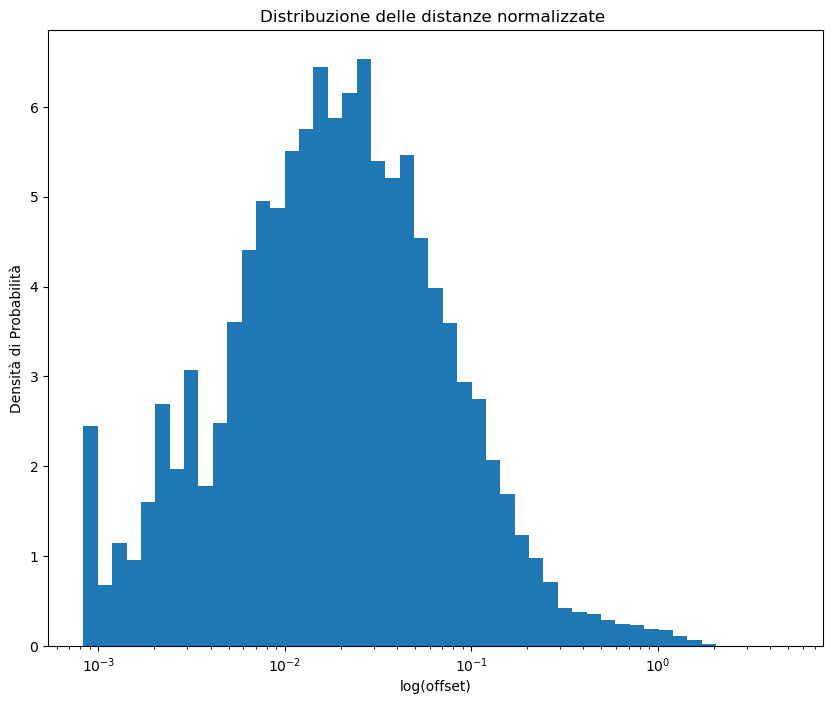

In [259]:

x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 50) #estremi degli intervalli
                                                                         #dell'istogramma


plt.figure(figsize=(10,8))

plt.hist(data["BCG_offset_R500"], x, density=True) #costruzione istogramma delle misure, normalizzato

plt.xscale('log')

plt.xlabel("log(offset)")
plt.ylabel("Densità di Probabilità")
plt.title("Distribuzione delle distanze normalizzate ")

plt.show()


Per studiare la dipendenza della distribuzione dal redshift, si suddivide il range di valori di redshift assunti dal campione in un certo numero di intervalli. Si ripartiscono i dati raccolti in 
sottocampioni caratterizzati da valori di redshift nello stesso intervallo, e per ognuno dei sottocampioni si costruisce l'istogramma delle misure di offset, e lo si normalizza. Poichè la distribuzione dipende dal redshift, questi istogrammi assumeranno forme diverse.

Lo stesso procedimento viene ripetuto per analizzare la dipendenza dalla massa (espressa come logaritmo della massa dell’ammasso di galassie in unità di massa solare).

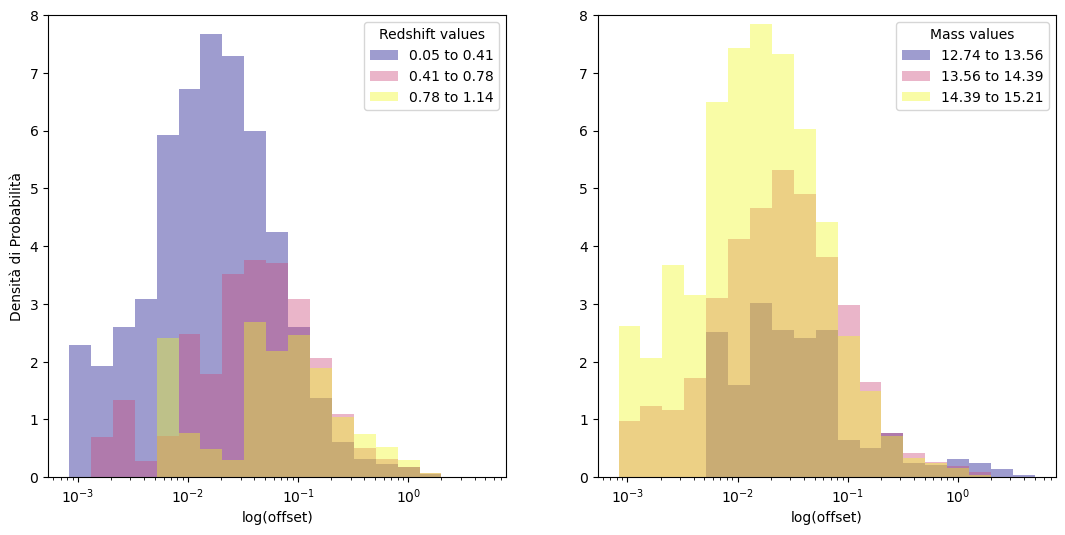

In [262]:
plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)

Nbins = 3
bins = pd.cut(data["BEST_Z"], bins=Nbins) #Si suddividono i dati raccolti in Nbins gruppi in base al
                                          #valore di redshift (colonna BEST_Z del catalogo)

cmap = plt.cm.get_cmap('plasma', Nbins)  
x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 20)

for i, (bin_value, group) in enumerate(data.groupby(bins)):
    color = cmap(i / (Nbins - 1))  
    plt.hist( group["BCG_offset_R500"],x,label=f'{bin_value.left:.2f} to {bin_value.right:.2f}',
             color=color, density=True, alpha=0.4)

plt.legend()
plt.plot()
plt.xscale("log")  
plt.ylim(0,8)
plt.xlabel("log(offset)")  
plt.ylabel("Densità di Probabilità")
plt.legend(title='Redshift values')

bins = pd.cut(data["logM500"], bins=Nbins) #Si suddividono i dati raccolti in Nbins gruppi in base al
                                           #valore di massa (colonna logM500 del catalogo)

plt.subplot(1, 2, 2)
for i, (bin_value, group) in enumerate(data.groupby(bins)):
    color = cmap(i / (Nbins - 1))  
    plt.hist( group["BCG_offset_R500"],x,label=f'{bin_value.left:.2f} to {bin_value.right:.2f}',
             color=color, density=True, alpha=0.4)

plt.legend(title='Mass values') 
plt.plot()
plt.xscale("log")              
plt.xlabel("log(offset)") 
plt.ylim(0,8)

plt.show()

Si nota come all'aumentare del redshift, il massimo della distribuzione diminuisce, e i valori di offset aumentano (la distribuzione "si allarga"). Viceversa, all'aumentare della massa dell'ammasso di galassie, il massimo della distribuzione aumenta, e i valori di offset diminuiscono (la distribuzione "si stringe").  

## 3. Sviluppo dei modelli

Per predire la distribuzione osservata di distanza normalizzata x tra
il centro determinato in banda X ed il centro determinato in banda ottica si
considerano i seguenti due modelli, dove una frazione $\rho$ di ammassi ben centrati viene
descritta dal parametro $\sigma_0$, ed una frazione 1−$\rho$  di ammassi centrati erroneamente viene
descritta dal parametro $\sigma_1$.

### Modello S15 (Saro et al. 2015)

$$
P(x|\rho,\sigma_0, \sigma_1) = \rho \cdot \frac{x}{\sigma_0^2} \cdot exp\left(-0.5 \cdot \left(\frac{x}{\sigma_0}\right)^2\right)+(1-\rho)\cdot \frac{x}{\sigma_1^2} \cdot exp\left(-0.5 \cdot \left(\frac{x}{\sigma_1}\right)^2\right)
$$

### Modello Z19 (Zhang et al. 2019)

$$
P(x|\rho,\sigma_0, \sigma_1) = \rho \cdot \frac{1}{\sigma_0} \cdot exp\left(\frac{x}{\sigma_0}\right)+(1-\rho)\cdot \frac{x}{\sigma_1^2} \cdot exp\left(-\frac{x}{\sigma_1}\right)
$$

Per studiare la dipendenza dai parametri, si graficano le funzioni facendo variare un parametro alla volta, tenendo fissi gli altri due. Gli intervalli considerati per la variazione dei parametri sono scelti sulla base di considerazioni sul loro significato fisico: $\rho$ è una frazione di ammassi e perciò può assumere valori solo tra 0 e 1. Il modello S15 dipende solo dal quadrato dei parametri $\sigma_0$ e $\sigma_1$ e per semplicità li si prendono positivi (non possono annullarsi in quanto la funzione divergerebbe). Per quanto riguarda il modello Z19, invece, la positività di $\sigma_0$ e $\sigma_1$ è obbligata dal fatto che la funzione divergerebbe altrimenti. 
Per l'analisi dei modelli si considerano solo valori non negativi per x, in quanto rappresenta una distanza.

### 3.1 Modello S15

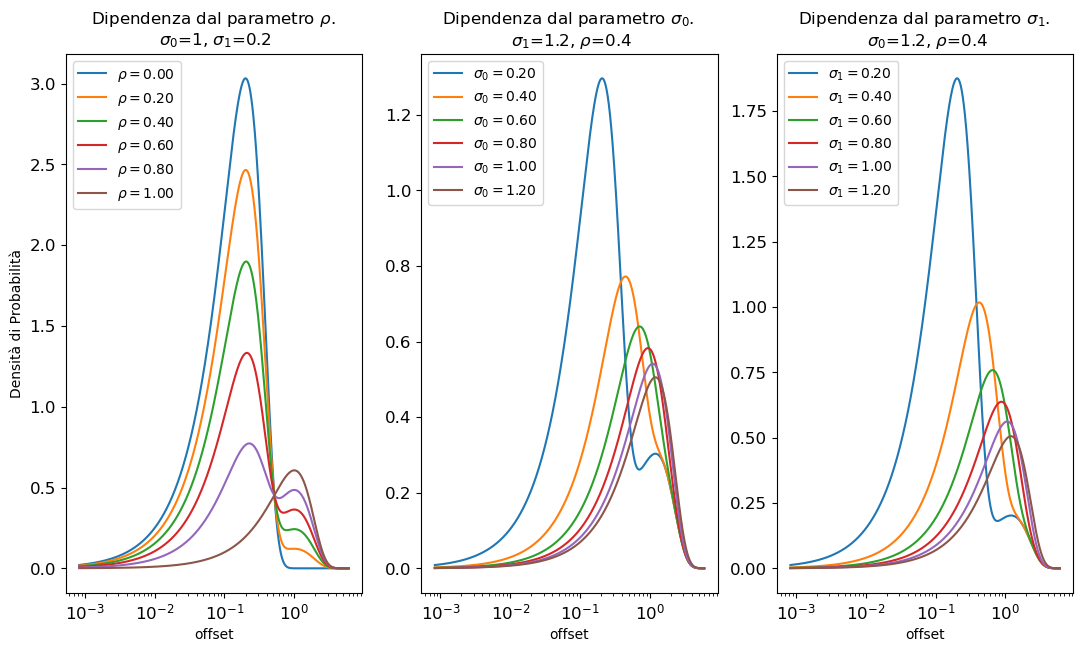

In [267]:
xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(6), 1000)
#valori di x per i quali si campiona il modello per graficarlo: poichè nel corso dell'analisi si usa 
#la scala logaritmica per l'asse delle ascisse, questa scelta viene fatta anche nello studiare 
#l'andamento con i parametri, per un confronto più immediato tra la forma della curva e i dati



fig, axes = plt.subplots(1,3, figsize=(13, 7))

n=6        #numero di valori diversi considerati per ciascun parametro

cmap = plt.cm.get_cmap('plasma', n)  

for i in range(n): #Si fanno variare i parametri in manira uniforme, uno alla volta tenendo gli altri
                   #due fissi
    
    color = cmap(i / (n - 1)) 
    axes[0].plot(xarr, model_S15([0.2*(i),1,0.2], xarr), label=r"$\rho={0:.2f}$".format(0.2*(i)))
    axes[1].plot(xarr, model_S15([0.4,0.2*(i+1),1.2], xarr), 
                 label=r"$\sigma_0={0:.2f}$".format(0.2*(i+1))) 
    axes[2].plot(xarr, model_S15([0.4,1.2,0.2*(i+1)], xarr), 
                 label=r"$\sigma_1={0:.2f}$".format(0.2*(i+1)))

for i in range(3):
    axes[i].set_xlabel("offset")
    axes[i].legend()
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].set_xscale("log")



axes[0].set_ylabel("Densità di Probabilità")
axes[0].set_title('Dipendenza dal parametro {}. \n {}=1, {}=0.2 '.format(r"$\rho$", r"$\sigma_0$",
                                                                         "$\sigma_1$"))
axes[1].set_title('Dipendenza dal parametro {1}. \n {2}=1.2, {0}=0.4 '.format(r"$\rho$",
                                                                        r"$\sigma_0$", "$\sigma_1$"))
axes[2].set_title('Dipendenza dal parametro {2}. \n {1}=1.2, {0}=0.4 '.format(r"$\rho$",
                                                                    r"$\sigma_0$", "$\sigma_1$"))


plt.show()

Si noti che, per maggiore visibilità, l'asse delle ordinate non coincide per i tre grafici. All'aumentare di $\rho$, il primo picco della funzione diminuisce, mentre il secondo aumenta.  All'aumentare di $\sigma_0$ e di $\sigma_1$, il picco della funzione diminuisce e si sposta a valori più alti di x. Si nota inoltre che in base ai valori dei tre parametri la funzione ha uno o due picchi (o "ginocchi"). 

### 3.2 Modello Z19

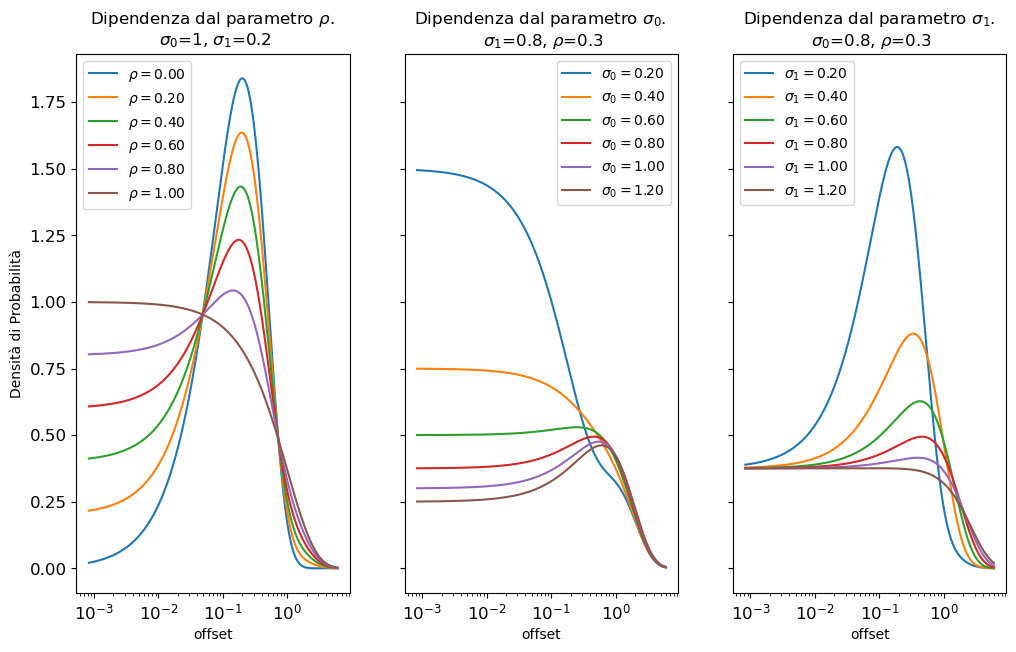

In [271]:
xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(6), 1000)

fig, axes = plt.subplots(1,3, figsize=(12, 7), sharey=True) #in questo caso l'asse delle ordinate è
                                                            #condiviso

n=6

cmap = plt.cm.get_cmap('plasma', n)  

for i in range(n): #Si fanno variare i parametri in manira uniforme, uno alla volta tenendo gli altri
                   #due fissi
    
    color = cmap(i / (n - 1)) 
    axes[0].plot(xarr, model_Z19([0.2*(i),1,0.2], xarr), label=r"$\rho={0:.2f}$".format(0.2*(i)))
    axes[1].plot(xarr, model_Z19([0.3,0.2*(i+1),0.8], xarr), 
                 label=r"$\sigma_0={0:.2f}$".format(0.2*(i+1))) 
    axes[2].plot(xarr, model_Z19([0.3,0.8,0.2*(i+1)], xarr), 
                 label=r"$\sigma_1={0:.2f}$".format(0.2*(i+1)))

for i in range(3):
    axes[i].set_xlabel("offset")
    axes[i].legend()
    axes[i].tick_params(axis='both', which='major', labelsize=12)
    axes[i].set_xscale("log")



axes[0].set_ylabel("Densità di Probabilità")
axes[0].set_title('Dipendenza dal parametro {}. \n {}=1, {}=0.2 '.format(r"$\rho$", 
                                                                r"$\sigma_0$", "$\sigma_1$"))
axes[1].set_title('Dipendenza dal parametro {1}. \n {2}=0.8, {0}=0.3 '.format(r"$\rho$",
                                                                r"$\sigma_0$", "$\sigma_1$"))
axes[2].set_title('Dipendenza dal parametro {2}. \n {1}=0.8, {0}=0.3 '.format(r"$\rho$",
                                                                r"$\sigma_0$", "$\sigma_1$"))


plt.show()

All'aumentare di $\rho$ la funzione diventa più stretta (la pendenza aumenta), e il valore del massimo aumenta. Il valore a x=0 dipende solo da $\rho$ e $\sigma_0$. All'aumentare di $\sigma_0$ e $\sigma_1$ il picco (o il "ginocchio") della funzione diminuisce e si sposta a valori più alti di x. Di nuovo, in base ai tre valori assunti dai parametri la funzione presenta uno o due picchi (o "ginocchi"), più o meno pronunciati.

## 4. Analisi Bayesiana
L'approccio bayesiano alla stima dei parametri consiste nell'utilizzare l'equazione di Bayes per "aggiornare" la probabilità a priori dei parametri p di un certo modello M -P(p|M)- sfruttando la probabilità P(d|pM) di ottenere un certo set di dati d fissando i parametri.
$$
P(p|d M) = \frac{P(d|p M) \cdot P(p|M)}{P(d|M)}
$$

Utilizzando l'algoritmo emcee si ottengono le posterior distribution per i parametri a partire dai dati a disposizione. Si procede separatamente per i due modelli. In entrambi i casi si assumono distribuzioni a priori piatte per i parametri. Tenendo conto delle considerazioni precedenti, questo vuol dire che i valori possibili per i parametri ($0 \le \rho \le 1$, $\sigma_0>0, \sigma_1>0$), vengono considerati equiprobabili a priori. Il fattore P(d|M), essendo indipendente dai parametri, viene trascurato a questo livello di analisi. 

### 4.1 Modello S15

In [275]:
np.random.seed(42)
nll = lambda *args: -log_posterior_S15(*args)
initial = np.array([0.5, 1.,1.])
soln = minimize(nll, initial, args=data.BCG_offset_R500) 
rho_bf, s0_bf, s1_bf = soln.x

pos = soln.x *(1+ 1e-2 * np.random.randn(32, 3))  #definisco la posizione iniziale nello spazio
                                                  #dei parametri

nwalkers, ndim = pos.shape   # numero di walker e di parametri da fittare
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior_S15, args=(data["BCG_offset_R500"],))
sampler.run_mcmc(pos, 3000, progress=True);

100%|███████████████████████████████████████| 3000/3000 [00:36<00:00, 82.46it/s]


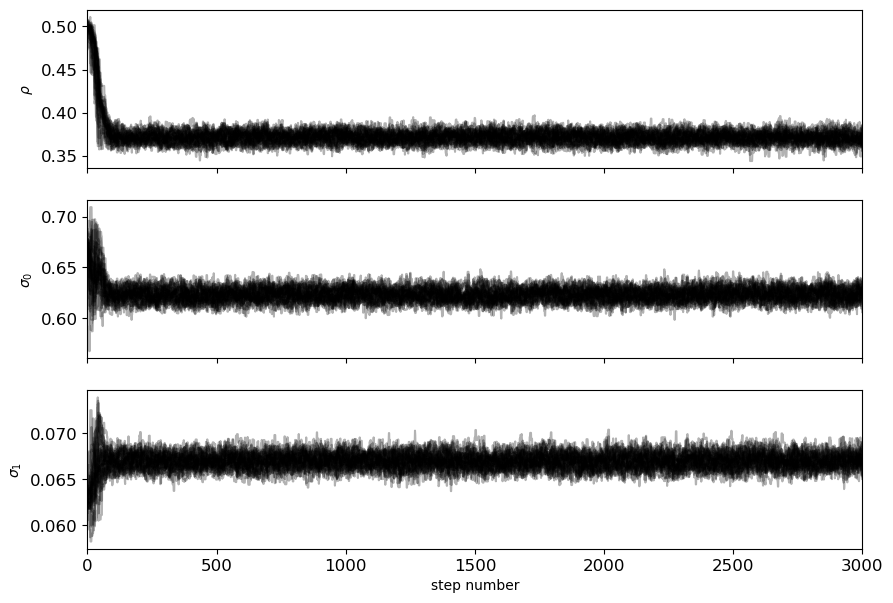

In [277]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True) 
samples1 = sampler.get_chain() #  Salvo nella variabile samples1 i valori assunti dai camminatori
                               #  nel campionamento della posterior distribution

labels = [r"$\rho$", r"$\sigma_0$", "$\sigma_1$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples1))
    ax.set_ylabel(labels[i])
    ax.tick_params(axis='both', which='major', labelsize=12)

axes[-1].set_xlabel("step number");

L'andamento dei valori assunti dai walker in funzione del numero di step indica che l'algoritmo è giunto a convergenza. Per analizzare i campioni generati, si deve tralasciare il transiente (fase di burn in) necessario a raggiungere la distribuzione stazionaria. In seguito si calcolano parametri significativi della distribuzione.  

In [280]:
flat_samples = sampler.get_chain(discard=200, thin=2, flat=True) #Si definisce il campione, scartando
#i primi 200 step della catena come burn in, "appiattendo" la catena, e estraendo 1 valore ogni 2

log_like= sampler.get_log_prob(discard=200, thin=2, flat=True) #i valori assunti dal logaritmo della 
#posterior valutata sui valori dei parametri assunti in ogni step della catena


means=np.mean(flat_samples, axis=0) #array con le medie dei parametri sul campione
std=np.std(flat_samples, axis=0)    #array con le deviazioni standard dei parametri sul campione
best_fits=np.zeros(ndim)

label=['\u03C1','\u03C30','\u03C31']


for i in range(np.shape(flat_samples)[1]):
    best_fits[i]=flat_samples[np.argwhere(log_like==np.amax(log_like)),i] #i valori di best fit sono i 
    #parametri che hanno la massimizzano la posterior probability
    print(label[i], 'ha media: {0:.4f} e deviazione standard: {1:.4f}'.format(means[i],std[i]))
    print( 'il valore di best fit di',label[i],'è {0:.4g} \n'.format(  best_fits[i]))


corr=np.corrcoef(flat_samples.T)
print('Coefficienti di correlazione')
print('tra \u03C1 e \u03C30:',np.round(corr,2)[0][1]) 
print('tra \u03C1 e \u03C31:',np.round(corr,2)[0][2]) 
print('tra \u03C30 e \u03C31:',np.round(corr,2)[1][2]) 


ρ ha media: 0.3719 e deviazione standard: 0.0065
il valore di best fit di ρ è 0.3716 

σ0 ha media: 0.6233 e deviazione standard: 0.0064
il valore di best fit di σ0 è 0.6231 

σ1 ha media: 0.0670 e deviazione standard: 0.0008
il valore di best fit di σ1 è 0.06702 

Coefficienti di correlazione
tra ρ e σ0: -0.21
tra ρ e σ1: -0.39
tra σ0 e σ1: 0.3


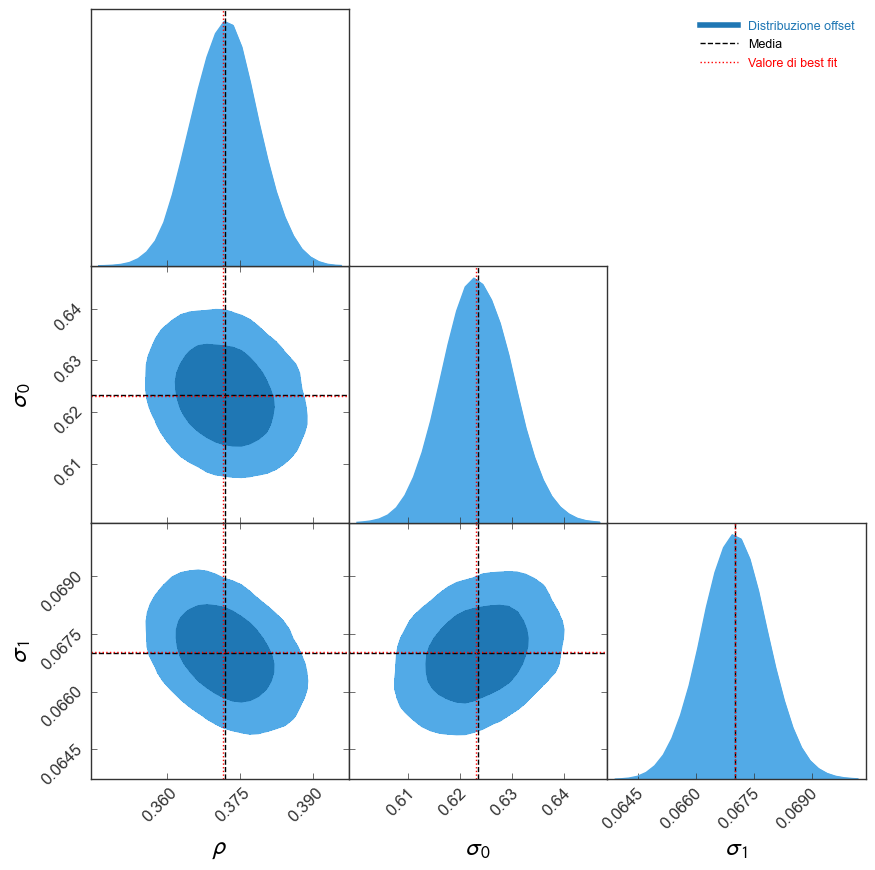

In [282]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$","$\sigma_0$","$\sigma_1$"], figureSize=10, 
                    customLabelFont={'family':'Arial', 'size':18},
                    customTickFont={'family':'Arial', 'size':12},truths=(means,best_fits),
                    truthColors=('k','r'),
                    truthLabels=('Media','Valore di best fit'), chainLabels=['Distribuzione offset'])
                    #default: 68% and 95% contour levels

Sopra si sono graficate le distribuzioni a posteriori marginalizzate dei parametri, evidenziando in nero la media e in rosso il valore di best fit. Si sono costruiti istogrammi due dimensionali considerando due parametri alla volta, con le curve di livello evidenziate che contengono il 68% e il 95% di probabilità. 

Gli assi principali delle ellissi non sono paralleli agli assi cartesiani, per cui già visivamente si intuisce che i parametri sono tra di loro correlati.

Per valutare la capacità del modello di riprodurre i dati, si sovrappone all'istogramma delle misure il modello, utilzzando sia la media dei parametri campionati, che i parametri che massimizzano la probabilità. Le due curve così ottenute si sovrappongono tra di loro. 

Si vuole propagare l'incertezza associata al modello, cioè l'incertezza sui parametri, nello spazio dei dati osservati. In particolare si procede estraendo un sottocampione di parametri dalla distribuzione a posteriori (già campionata con l'algoritmo emcee). Un modo per quantificare l'incertezza teorica sul valore della distribuzione, per ogni valore di massa, è calcolare il sedicesimo, cinquantesimo e ottantaquattresimo percentile dei valori ottenuti con i parametri sottocampionati. Il cinquantesimo percentile corrisponde alla mediana (che si vede essere sovrapposta alle curve ottenute con la media e il valore di best fit dei parametri), e l'intervallo di confidenza è dato dai valori centrati sulla mediana che contengono il 68% della probabilità.

Bisogna definire una statistica di test per valutare la bontà del fit.
Supponendo che la distribuzione degli offset sia descritta dal modello S15, se si ha a disposizione un campione sufficientemente grande di n misure indipendenti di offset per costruire un istogramma (con numero di intervalli N fissato), si può assumere che il numero di eventi $n_k$ in un intervallo segua una distribuzione multinomiale, con valore di aspettazione $n \cdot p_k$ e deviazione standard $\sqrt{n p_k (1-p_k)}$, dove $p_k$ è la probabilità che il singolo evento cada nel k-esimo intervallo e si ottiene integrando la funzione di distribuzione. Se le $p_k$ sono sufficentemente piccole (inferiori al 10%), la correlazione tra gli eventi attesi in due intervalli diversi è trascurabile in prima approssimazione. Inoltre se i valori di aspettazione $\mu_k$ sono sufficentemente grandi (per esempio maggiori di 10) la distribuzione tende ad una multinormale, e la statistica 
$$t=\sum_{k=1}^N \left(\frac{n_k-\mu_k}{\sigma_k}\right)^2$$
ha distribuzione di $\chi^2$ con N-1-l gradi di libertà, se l è il numero di parametri stimati dal campione di dati. t può essere usata come statistica di test per eseguire il test d'ipotesi che la distribuzione degli offset sia descritta dal modello considerato. 

Text(0, 0.5, 'Distribuzione di probabilità')

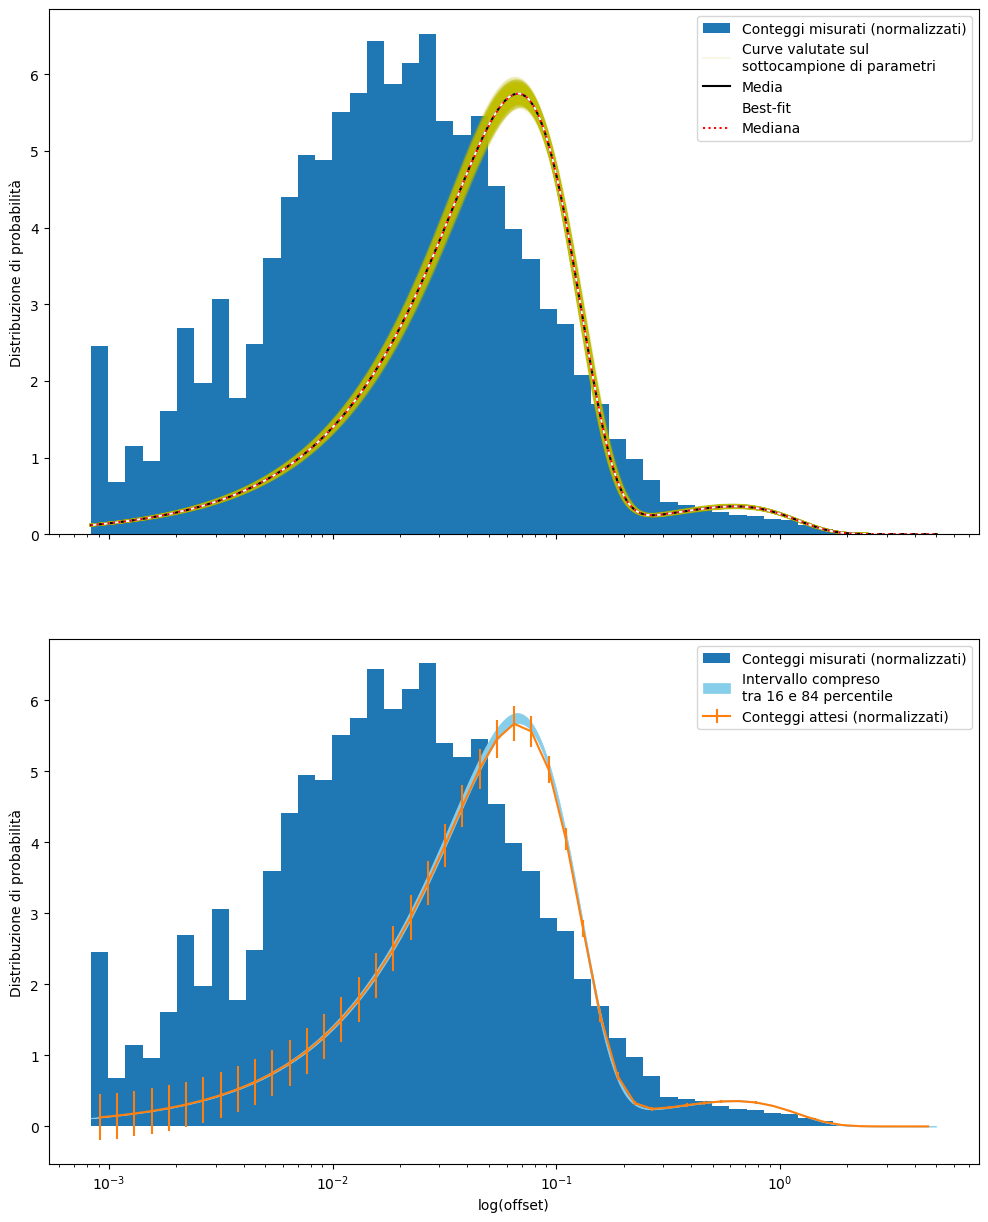

In [288]:
fig, ax = plt.subplots(2, figsize=(12, 15),sharex=True)

x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 50)   
#estremi degli intervalli dell'istogramma



xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 1000)
#valori ai quali si campionano le funzioni valutati sul sottocampione di parametri, per graficarle



Nsamples=1000                                                           #per Nsamples volte estraggo 
                                                                        #un indice della catena 

yarr = np.zeros((len(xarr),Nsamples)) #variabile in cui vengono salvati i campioni delle distribuzioni
                                      #calcolate con i diversi parametri

plt.xscale('log')

ax[0].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',density=True)

for i in range(Nsamples):                                               
    theta = flat_samples[ np.random.randint(len(flat_samples[:,0])) ,:] #estraggo un set di parametri
                                                                        #dal campione...
    yarr[:,i] = model_S15(theta, xarr)                                  #...e campiono il modello
    if i==0:
        ax[0].plot(xarr, yarr[:,i],"y", label='Curve valutate sul \nsottocampione di parametri',
                   alpha=0.1)
    else:
        ax[0].plot(xarr,yarr[:,i], "y" ,alpha=0.1)

ax[0].plot(xarr, model_S15(means, xarr), c="k",label='Media')
ax[0].plot(xarr, model_S15(best_fits, xarr), c="w",ls='--',label='Best-fit')
ax[0].plot(xarr, np.percentile(yarr,50,axis=1), c="r",ls=':',label='Mediana') #campioni della 
#distribuzione valutata sulla media dei parametri

ax[1].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',
                       density=True) #valori dei conteggi (normalizzati)


ax[1].fill_between(xarr,np.percentile(yarr,16,axis=1),np.percentile(yarr,84,axis=1),color="skyblue",
                   lw=0.5, label='Intervallo compreso \ntra 16 e 84 percentile')


bin_centres=(x[1:]+x[:-1])/2
bin_width=x[1:]-x[:-1]

values=np.histogram(data["BCG_offset_R500"],x)  #valori dei conteggi

n_tot=len(data["BCG_offset_R500"])
dx=xarr[1]-xarr[0]

errors=np.zeros(len(values[0]))
expected=np.zeros(len(values[0]))
p=np.zeros(len(values[0]))
normalization=sum(values[0])*bin_width #normalizzazione dell'istogramma dei valori misurati


for i in range(len(values[0])):
    del_t=x[i]+np.arange(100)*((x[i+1]-x[i])/100) #si divide ogni intervallo dell'istogramma in 
    #intervallini in modo da integrare la disrtribuzione (valutata sui parametri di best fit) con 
    #il metode dei trapezi
    p[i]=np.trapz(model_S15(best_fits,del_t),del_t) #probabilità che un dato cada nell'intervallo
    #i-esimo
    expected[i]=p[i]*n_tot #valore di aspettazione dei conteggi nell'intervallo i-esimo
    errors[i]=np.sqrt(expected[i]*(1-p[i])) #incertezza sul numero di conteggi nell'intervallo i-esimo
    
ax[1].errorbar(bin_centres, expected/normalization ,yerr=errors/normalization,
               label='Conteggi attesi (normalizzati)')


ax[0].legend()
ax[1].legend()

ax[1].set_xlabel('log(offset)')

ax[0].set_ylabel('Distribuzione di probabilità')
ax[1].set_ylabel('Distribuzione di probabilità')



Si può già osservare che qualitativamente l'andamento dei dati non è descritto accuratamente dal modello. Per essere più quantitativi si calcola la statistica t, considerando solo gli intervalli dove valgono le ipotesi per cui in prima approssimazione essa segue una distribuzione di $\chi^2$. Gli intervalli rimanenti vanno trattati a parte.

In [290]:
print("Il numero di intervalli dell'istogramma costruito con il data set è ",len(values[0]))
print("\nGli indici k, tali per cui il valore di aspettazione per i conteggi (non normalizzati)",
      " nell'intervallo k-esimo è minore di 10 sono",np.where(expected<10)[0])
if len(np.where(expected<10)[0])>0:
    print("Per ognuno di essi, si riporta la differenza tra il valore atteso e quello misurato", 
      ",tutto diviso per la deviazione standard")
    for i in np.where(expected<10)[0]:
        print(i,": {0:.2f}".format((values[0][i]-expected[i])/errors[i]))

print("\nGli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è maggiore",
      " di 0.1 sono", np.where(p>0.1)[0])

if len(np.where(p>0.1)[0])>0:
    print("Per ognuno di essi, si riporta la differenza tra il valore atteso e quello misurato", 
      ",tutto diviso per la deviazione standard")
    for i in np.where(p>0.1)[0]:
        print(i,":{0:.2f}".format((values[0][i]-expected[i])/errors[i]))

dof=len(values[0]) -len(np.where(expected<10)[0])-len(np.where(p>0.1)[0])-ndim-1 #I gradi di libertà
#sono il numero di intervalli considerati, meno i parametri stimati dal campione, meno 1

chisq=np.sum(np.where(np.all([expected>10,p<0.1], axis=0),((values[0]-expected)/errors)**2, 0 ))

alpha=0.05 #Livello di significatività con il quale si testa l'ipotesi che il modello sia un buon 
#fit per i dati

print("\nNumero di gradi di libertà:", dof)
print('Chi quadro best fit:{0:.2f}'.format(chisq))
print('Valore critico (Livello di significatività=0.05):{0:.2f}'.format(chi2.ppf(1 - alpha, dof)))
print('Chi quadro ridotto best fit ={0:.2f}'.format(chisq/dof))


Il numero di intervalli dell'istogramma costruito con il data set è  49

Gli indici k, tali per cui il valore di aspettazione per i conteggi (non normalizzati)  nell'intervallo k-esimo è minore di 10 sono [ 0  1  2  3  4  5  6  7  8  9 10 11 45 46 47 48]
Per ognuno di essi, si riporta la differenza tra il valore atteso e quello misurato ,tutto diviso per la deviazione standard
0 : 7.22
1 : 1.65
2 : 3.00
3 : 2.31
4 : 4.19
5 : 7.40
6 : 4.98
7 : 8.15
8 : 3.89
9 : 5.76
10 : 8.87
11 : 10.93
45 : 5.51
46 : 43.53
47 : 206.16
48 : 1504.11

Gli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è maggiore  di 0.1 sono []

Numero di gradi di libertà: 29
Chi quadro best fit:2492.36
Valore critico (Livello di significatività=0.05):42.56
Chi quadro ridotto best fit =85.94


La statistica valutata sul campione è molto maggiore del valore critico, e l'ipotesi che la miscentering distribution sia descritta dal modello S15 deve essere rigettata con un livello di significatività del 5%. Infatti il valore del chi quadro ridotto è molto maggiore di 1, e il modello non è un buon fit per i dati. 



### 4.2 Modello Z19
Si procede nello stesso modo per analizzare il campione, questa volta considerando il modello Z19 per la distribuzione degli offset.

In [292]:
np.random.seed(42)
nll = lambda *args: -log_posterior_Z19(*args)
initial = np.array([0.5, 1.,1.])
soln = minimize(nll, initial, args=data.BCG_offset_R500)
rho_bf, s0_bf, s1_bf = soln.x
pos = soln.x *(1+ 1e-2 * np.random.randn(32, 3)) #Si definisce la posizione iniziale nello spazio
                                                  #dei parametri

nwalkers, ndim = pos.shape   # numero di walker e di parametri da fittare
sampler = emcee.EnsembleSampler( nwalkers, ndim, log_posterior_Z19, args=(data["BCG_offset_R500"],))
sampler.run_mcmc(pos, 3000, progress=True);


100%|██████████████████████████████████████| 3000/3000 [00:27<00:00, 109.84it/s]


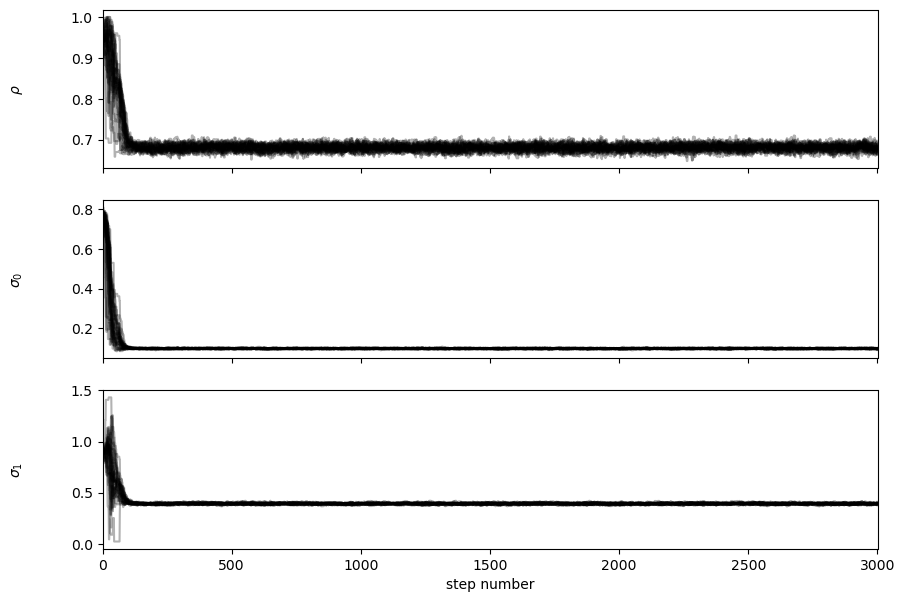

In [294]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples1 = sampler.get_chain() #  Salvo nella variabile samples1 i valori assunti dai camminatori
                               #  nel campionamento della posterior distribution
labels = [r"$\rho$", r"$\sigma_0$", "$\sigma_1$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples1[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples1))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");


L'andamento dei valori assunti dai walker in funzione del numero di step indica che l'algoritmo è giunto a convergenza, e per analizzare i campioni generati si deve tralasciare la fase di burn in.  In seguito si calcolano parametri significativi della distribuzione e si graficano le distribuzioni a posteriori marginalizzate dei parametri, evidenziando in nero la media e in rosso il valore di best fit. Inoltre si costruiscono istogrammi due dimensionali considerando due parametri alla volta, con le curve di livello evidenziate che contengono il 68% e il 95% di probabilità. 

In [297]:
flat_samples = sampler.get_chain(discard=200, thin=2, flat=True) #Si definisce il campione, scartando
#i primi 200 step della catena come burn in, "appiattendo" la catena, e estraendo 1 valore ogni 2

log_like= sampler.get_log_prob(discard=200, thin=2, flat=True) #i valori assunti dal logaritmo della 
#posterior valutata sui valori dei parametri assunti in ogni step della catena


means=np.mean(flat_samples, axis=0)
std=np.std(flat_samples, axis=0)
best_fits2=np.zeros(ndim)

label=['\u03C1','\u03C30','\u03C31']


for i in range(np.shape(flat_samples)[1]):
    best_fits2[i]=flat_samples[np.argwhere(log_like==np.amax(log_like)),i] #i valori di best fit sono i 
    #parametri che hanno la massimizzano la posterior probability
    print(label[i], 'ha media: {0:.4f} e deviazione standard: {1:.4f}'.format(means[i],std[i]))
    print( 'il valore di best fit di',label[i],'è {0:.4g} \n'.format(  best_fits2[i]))


corr=np.corrcoef(flat_samples.T)
print('Coefficienti di correlazione')
print('tra \u03C1 e \u03C30:',np.round(corr,2)[0][1]) 
print('tra \u03C1 e \u03C31:',np.round(corr,2)[0][2]) 
print('tra \u03C30 e \u03C31:',np.round(corr,2)[1][2]) 

ρ ha media: 0.6806 e deviazione standard: 0.0078
il valore di best fit di ρ è 0.6805 

σ0 ha media: 0.0988 e deviazione standard: 0.0021
il valore di best fit di σ0 è 0.09868 

σ1 ha media: 0.3920 e deviazione standard: 0.0072
il valore di best fit di σ1 è 0.392 

Coefficienti di correlazione
tra ρ e σ0: 0.5
tra ρ e σ1: 0.46
tra σ0 e σ1: 0.4


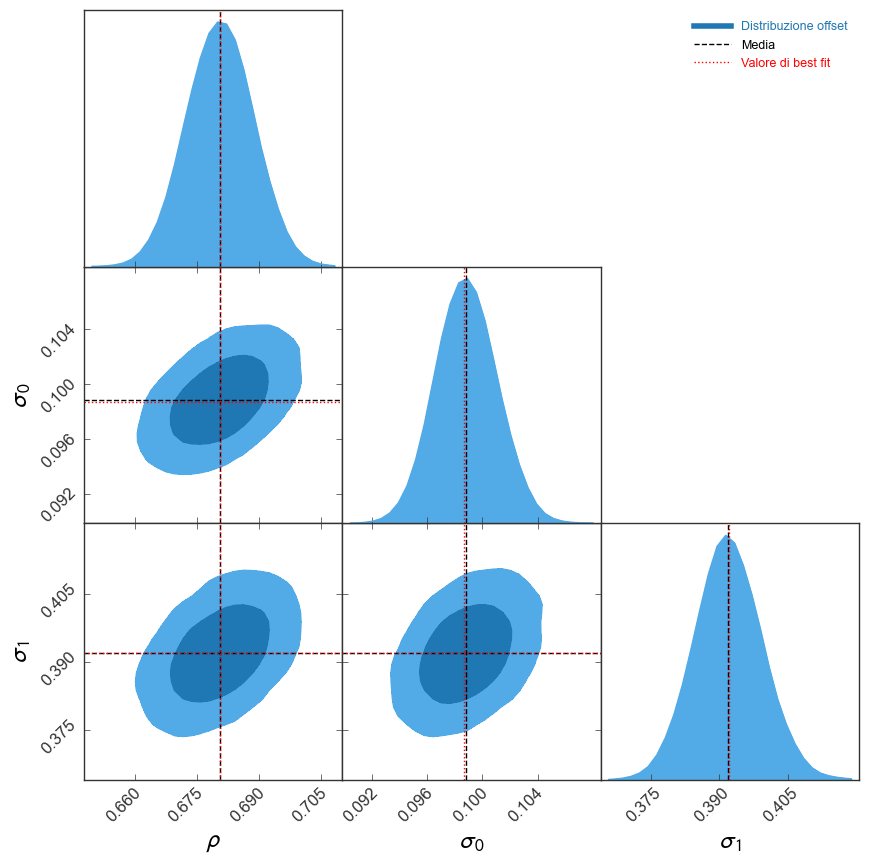

In [301]:
GTC = pygtc.plotGTC(chains=flat_samples,
                    paramNames=[r"$\rho$","$\sigma_0$","$\sigma_1$"], figureSize=10, 
                    customLabelFont={'family':'Arial', 'size':18},
                    customTickFont={'family':'Arial', 'size':12},truths=(means,best_fits2),truthColors=('k','r'),
                    truthLabels=('Media','Valore di best fit'), chainLabels=['Distribuzione offset'])
                    #default: 68% and 95% contour levels

Di nuovo si sovrappongono all'istogramma normalizzato degli offset misurati le funzioni di distribuzione secondo il modello Z19, usando i parametri medi e quelli di best fit. Di nuovo viene estratto un sottocampione di parametri dalla catena generata dall'algoritmo emcee e per ogni valore di offset si calcolano il sedicesimo, cinquantesimo e ottantaquattresimo percentile dei valori ottenuti. Le curve ottenute per ogni set di parametri del sottocampione vengono normalizzate con la curva valutata sui parametri medi e sovrapposte all'istogramma normalizzato con la media del dataset. Infine per valutare la bontà del fit viene utilizzato la stessa statistica di prima, t.

Text(0, 0.5, 'Distribuzione di probabilità')

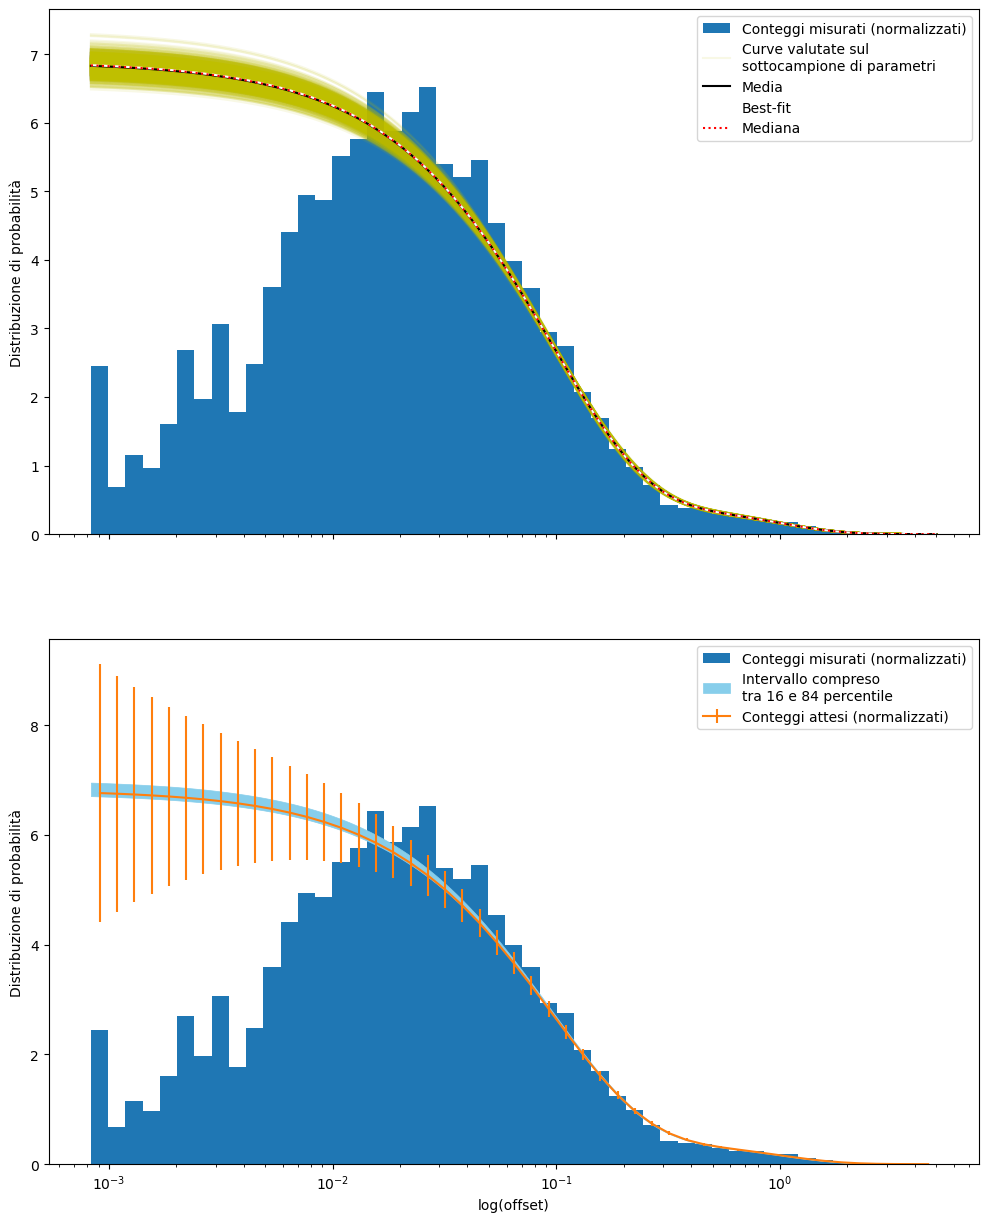

In [319]:
fig, ax = plt.subplots(2, figsize=(12, 15),sharex=True)

x=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 50)
#estremi degli intervalli dell'istogramma

xarr=np.logspace(np.log10(np.min(data["BCG_offset_R500"])),np.log10(5), 1000)
#valori ai quali si campionano le funzioni valutati sul sottocampione di parametri, per graficarle

Nsamples=1000                                                           #per Nsamples volte estraggo 
                                                                        #un indice della catena 

yarr = np.zeros((len(xarr),Nsamples)) #variabile in cui vengono salvati i campioni delle distribuzioni
                                      #calcolate con i diversi parametri

mean_relation=model_Z19(means, xarr)  #campioni della distribuzione valutata sulla media dei parametri

plt.xscale('log')

ax[0].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',density=True)

for i in range(Nsamples):                                               
    theta = flat_samples[ np.random.randint(len(flat_samples[:,0])) ,:]  #estraggo un set di parametri
                                                                        #dal campione...
    yarr[:,i] = model_Z19(theta, xarr)                                  #...e campiono il modello
    if i==0:
        ax[0].plot(xarr, yarr[:,i],"y", label='Curve valutate sul \nsottocampione di parametri',
                   alpha=0.1)
    else:
        ax[0].plot(xarr,yarr[:,i], "y" ,alpha=0.1)
 
ax[0].plot(xarr, mean_relation, c="k",label='Media')
ax[0].plot(xarr, model_Z19(best_fits2, xarr), c="w",ls='--',label='Best-fit')
ax[0].plot(xarr, np.percentile(yarr,50,axis=1), c="r",ls=':',label='Mediana') #campioni della 
#distribuzione valutata sulla media dei parametri



ax[1].hist(data["BCG_offset_R500"],x,label='Conteggi misurati (normalizzati)',density=True)
           #valori dei conteggi (normalizzati)



ax[1].fill_between(xarr,np.percentile(yarr,16,axis=1),np.percentile(yarr,84,axis=1),color="skyblue",
                   lw=0.5, label='Intervallo compreso \ntra 16 e 84 percentile')

bin_centres=(x[1:]+x[:-1])/2
bin_width=x[1:]-x[:-1]
values=np.histogram(data["BCG_offset_R500"],x)  #valori dei conteggi

n_tot=len(data["BCG_offset_R500"])
dx=xarr[1]-xarr[0]

errors2=np.zeros(len(values[0]))
expected2=np.zeros(len(values[0]))
p=np.zeros(len(values[0]))
normalization=sum(values[0])*bin_width


for i in range(len(values[0])):
    del_t=x[i]+np.arange(100)*((x[i+1]-x[i])/100) #si divide ogni intervallo dell'istogramma in 
    #intervallini in modo da integrare la disrtribuzione (valutata sui parametri di best fit) con 
    #il metode dei trapezi
    p[i]=np.trapz(model_Z19(best_fits2,del_t),del_t) #probabilità che un dato cada nell'intervallo
    expected2[i]=p[i]*n_tot  #valore di aspettazione dei conteggi nell'intervallo i-esimo
    errors2[i]=np.sqrt(expected2[i]*(1-p[i])) #incertezza sul numero di conteggi nell'intervallo i-esimo
    
ax[1].errorbar(bin_centres, expected2/normalization ,yerr=errors2/normalization,
               label='Conteggi attesi (normalizzati)')

    
ax[0].legend()
ax[1].legend()

ax[1].set_xlabel('log(offset)')

ax[0].set_ylabel('Distribuzione di probabilità')
ax[1].set_ylabel('Distribuzione di probabilità')


Qualitativamente la funzione non descrive bene la parte iniziale del grafico, però in quella stessa zona gli errori sono più elevati. 

In [307]:
print("Il numero di intervalli dell'istogramma costruito con il data set è ",len(values[0]))
print("\nGli indici k, tali per cui il valore di aspettazione per i conteggi nell'intervallo k-esimo",
      "è maggiore di 10 sono", np.where(expected2<10)[0])
if len(np.where(expected2<10)[0])>0:
    print("Per ognuno di essi, si riporta la differenza tra il valore atteso e quello misurato", 
      ",tutto diviso per la deviazione standard")
    for i in np.where(expected2<10)[0]:
        print(i,": {0:.2f}".format((values[0][i]-expected2[i])/errors2[i]))
print("\nGli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è minore di 0.1",
      "sono", np.where(p>0.1)[0])

if len(np.where(p>0.1)[0])>0:
    print("Per ognuno di essi, si riporta la differenza tra il valore atteso e quello misurato", 
      ",tutto diviso per la deviazione standard")
    for i in np.where(p>0.1)[0]:
        print(i,":{0:.2f}".format((values[0][i]-expected2[i])/errors2[i]))

dof=len(values[0]) -len(np.where(expected2<10)[0])-len(np.where(p>0.1)[0])-ndim-1 #I gradi di libertà
#sono il numero di intervalli considerati, meno i parametri stimati dal campione, meno 1

chisq=np.sum(np.where(np.all([expected2>10,p<0.1], axis=0),((values[0]-expected2)/errors2)**2, 0 ))

alpha=0.05 #Livello di significatività con il quale si testa l'ipotesi che il modello sia un buon 
#fit per i dati

print("\nNumero di gradi di libertà:", dof)
print('Chi quadro best fit:', chisq)
print('Valore critico (Livello di significatività=0.05):',chi2.ppf(1 - alpha, dof))
print('Chi quadro ridotto best fit =',chisq/dof)

Il numero di intervalli dell'istogramma costruito con il data set è  49

Gli indici k, tali per cui il valore di aspettazione per i conteggi nell'intervallo k-esimo è maggiore di 10 sono [ 0  1 46 47 48]
Per ognuno di essi, si riporta la differenza tra il valore atteso e quello misurato ,tutto diviso per la deviazione standard
0 : -1.83
1 : -2.82
46 : 0.24
47 : 0.96
48 : 0.60

Gli indici k per cui la probabilià che un evento cada nell'intervallo k-esimo è minore di 0.1 sono []

Numero di gradi di libertà: 40
Chi quadro best fit: 258.81999330146357
Valore critico (Livello di significatività=0.05): 55.75847927888702
Chi quadro ridotto best fit = 6.470499832536589


Di nuovo, l'ipotesi che la miscentering distribution sia descritta dal modello Z19 va rigettata con un livello di significatività del 5%. In ogni caso il valore del chi quadro ridotto è più vicino ad 1 del caso precedente, e il valore della statistica è più vicino al valor critico. Questa osservazione è coerente con il fatto che la curva attesa per questo modello descrive meglio l'andamento dei dati (si veda la figura sottostante). Per quanto riguarda le code i valori attesi e osservati distano per meno di 3 deviazioni standard (tuttavia, la differenza tra il valore atteso e quello misurato, divisa per la deviazione standard, non ha una distribuzione gaussiana in questi casi).

Text(0.5, 1.0, 'Confronto tra i due modelli proposti e i dati misurati')

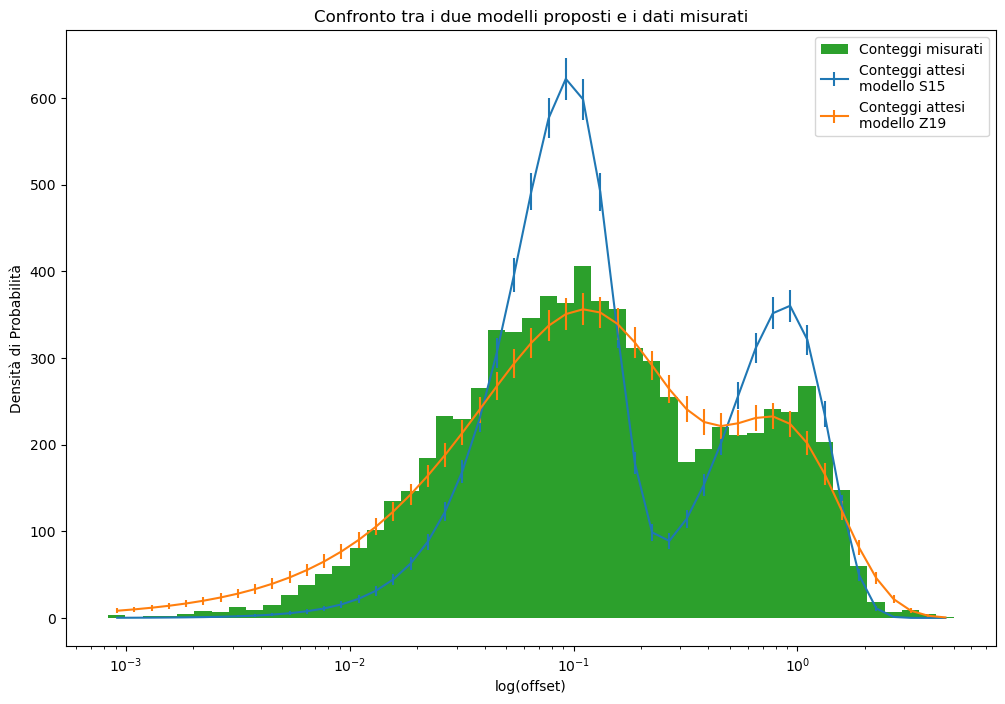

In [231]:
plt.figure(figsize=(12, 8))
plt.errorbar(bin_centres, expected, yerr=errors, label='Conteggi attesi \nmodello S15')
plt.errorbar(bin_centres, expected2, yerr=errors2, label='Conteggi attesi \nmodello Z19')
plt.hist(data["BCG_offset_R500"],x,label='Conteggi misurati')

plt.legend()
plt.xscale('log')
plt.xlabel("log(offset)")
plt.ylabel("Densità di Probabilità")
plt.title("Confronto tra i due modelli proposti e i dati misurati")



### 5. Conclusioni e commenti
Si è costruito un istogramma con le misure di offset a disposizione. Si è studiato l'andamento con il redshift e la massa. Si sono introdotti due modelli per descrivere la distribuzione e si sono calcolate le distribuzioni a posteriori per i parametri dei due modelli. Si sono quindi confrontati i risultati ottenuti con il dataset e valutando la bontà del fit con il test dei chi quadro si è giunti alla conclusione che entrambi i modelli non descrivono la distribuzione degli offset con un livello di significatività del 5%. In ogni caso, il modello Z19 descrive meglio il dataset a disposizione sia qualitativamente, che dal punto di vista dei valori assunti dalla statistica di test e dal chi quadro ridotto.

Per un'analisi più completa del dataset servirebbe avere a disposizione gli errori di misura sui valori di offset osservati. Se ciò non dovesse bastare ad avere compatibilità con il modello, si potrebbero introdurre nuovi parametri nella distribuzione, in modo da permettere alla funzione di adattarsi meglio ai dati.